# Assistant Tools
Give Assistants access to OpenAI-hosted tools like Code Interpreter and Knowledge Retrieval, or build your own tools using Function calling. Usage of OpenAI-hosted tools comes at an additional fee — visit [help center article](https://help.openai.com/en/articles/8550641-assistants-api) to learn more about how these tools are priced.

## Code Interpreter
Code Interpreter allows the Assistants API to write and run Python code in a sandboxed execution environment. This tool can process files with diverse data and formatting, and generate files with data and images of graphs. Code Interpreter allows your Assistant to run code iteratively to solve challenging code and math problems. When your Assistant writes code that fails to run, it can iterate on this code by attempting to run different code until the code execution succeeds.

Code Interpreter is charged at $0.03 per session. If your Assistant calls Code Interpreter simultaneously in two different threads (e.g., one thread per end-user), two Code Interpreter sessions are created. Each session is active by default for one hour, which means that you only pay for one session per if users interact with Code Interpreter in the same thread for up to one hour.

To enable it, pass the `code_interpreter` in the `tools` parameter of the Assistant object to enable Code Interpreter. The model then decides when to invoke Code Interpreter in a Run based on the nature of the user request. This behavior can be promoted by prompting in the Assistant's instructions (e.g., “write code to solve this problem”).

### Using Files with Code Interpreter
Code Interpreter can parse data from files. This is useful when you want to provide a large volume of data to the Assistant or allow your users to upload their own files for analysis. Note that files uploaded for Code Interpreter are not indexed for retrieval. See the Knowledge Retrieval section below for more details on indexing files for retrieval.

Files that are passed at the Assistant level are accessible by all Runs with this Assistant. Files can also be passed at individual Message level. These files are only accessible in the specific Thread.

In [20]:
from mlteam_utils import print_object
from openai import OpenAI
client = OpenAI()

# Upload a file with an "assistants" purpose
file = client.files.create(
  file=open("data/AG_news_samples.csv", "rb"),
  purpose='assistants'
)

# Create an assistant with 'code_interpreter' enabled
assistant = client.beta.assistants.create(
  name = "CSV Analyzer",
  instructions="You are an assistant that does exploratory data analysis given a dataset as a CSV file. When asked a question about the data, write and run code to answer the question.",
  model="gpt-4-turbo-preview",
  tools=[{"type": "code_interpreter"}]
)

thread = client.beta.threads.create()

message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="How many news are labeled as 'Sports'?",
    file_ids=[file.id]
)

run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

# Wait for Run to be completed
import time

while True:
    time.sleep(5)
    run = client.beta.threads.runs.retrieve(
      thread_id=thread.id,
      run_id=run.id
    )
    if run.status in ['queued', 'in_progress', 'requires_action', 'cancelling']:
        continue
    if run.status in ["completed", "expired", "failed", "cancelled"]:
        print(f"Run is {run.status}")
        break
    break

Run is completed


In [21]:
# Get the response
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

for message in reversed(messages.data):
  print(f"_______Role: {message.role}_______\n")
  print(f"{message.content[0].text.value}\n")

_______Role: user_______

How many news are labeled as 'Sports'?

_______Role: assistant_______

To answer your question, I'll first need to load and inspect the contents of the uploaded CSV file to find news entries labeled as 'Sports'. Let me start by loading the data.

_______Role: assistant_______

The dataset contains columns titled 'title', 'description', 'label_int', and 'label'. The 'label' column appears to include the categorization of each piece of news, including 'Sports'. 

I will now proceed to count how many news entries are labeled as 'Sports'.

_______Role: assistant_______

There are 491 news entries labeled as 'Sports' in the dataset.



### Reading images and files generated by Code Interpreter
Code Interpreter in the API also outputs files, such as generating image diagrams, CSVs, and PDFs. There are two types of files that are generated:

1. Images
2. Data files (e.g. a csv file with data generated by the Assistant)

When Code Interpreter generates an image, you can look up and download this file in the file_id field of the Assistant Message response.

In [22]:
# Add a new message to the previously created thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="Can you give me a plot diagram with 'label' in the x axis, and count in the y axis?"
)

run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

# Wait for Run to be completed
import time

while True:
    time.sleep(5)
    run = client.beta.threads.runs.retrieve(
      thread_id=thread.id,
      run_id=run.id
    )
    if run.status in ['queued', 'in_progress', 'requires_action', 'cancelling']:
        continue
    if run.status in ["completed", "expired", "failed", "cancelled"]:
        print(f"Run is {run.status}")
        break
    break

Run is completed


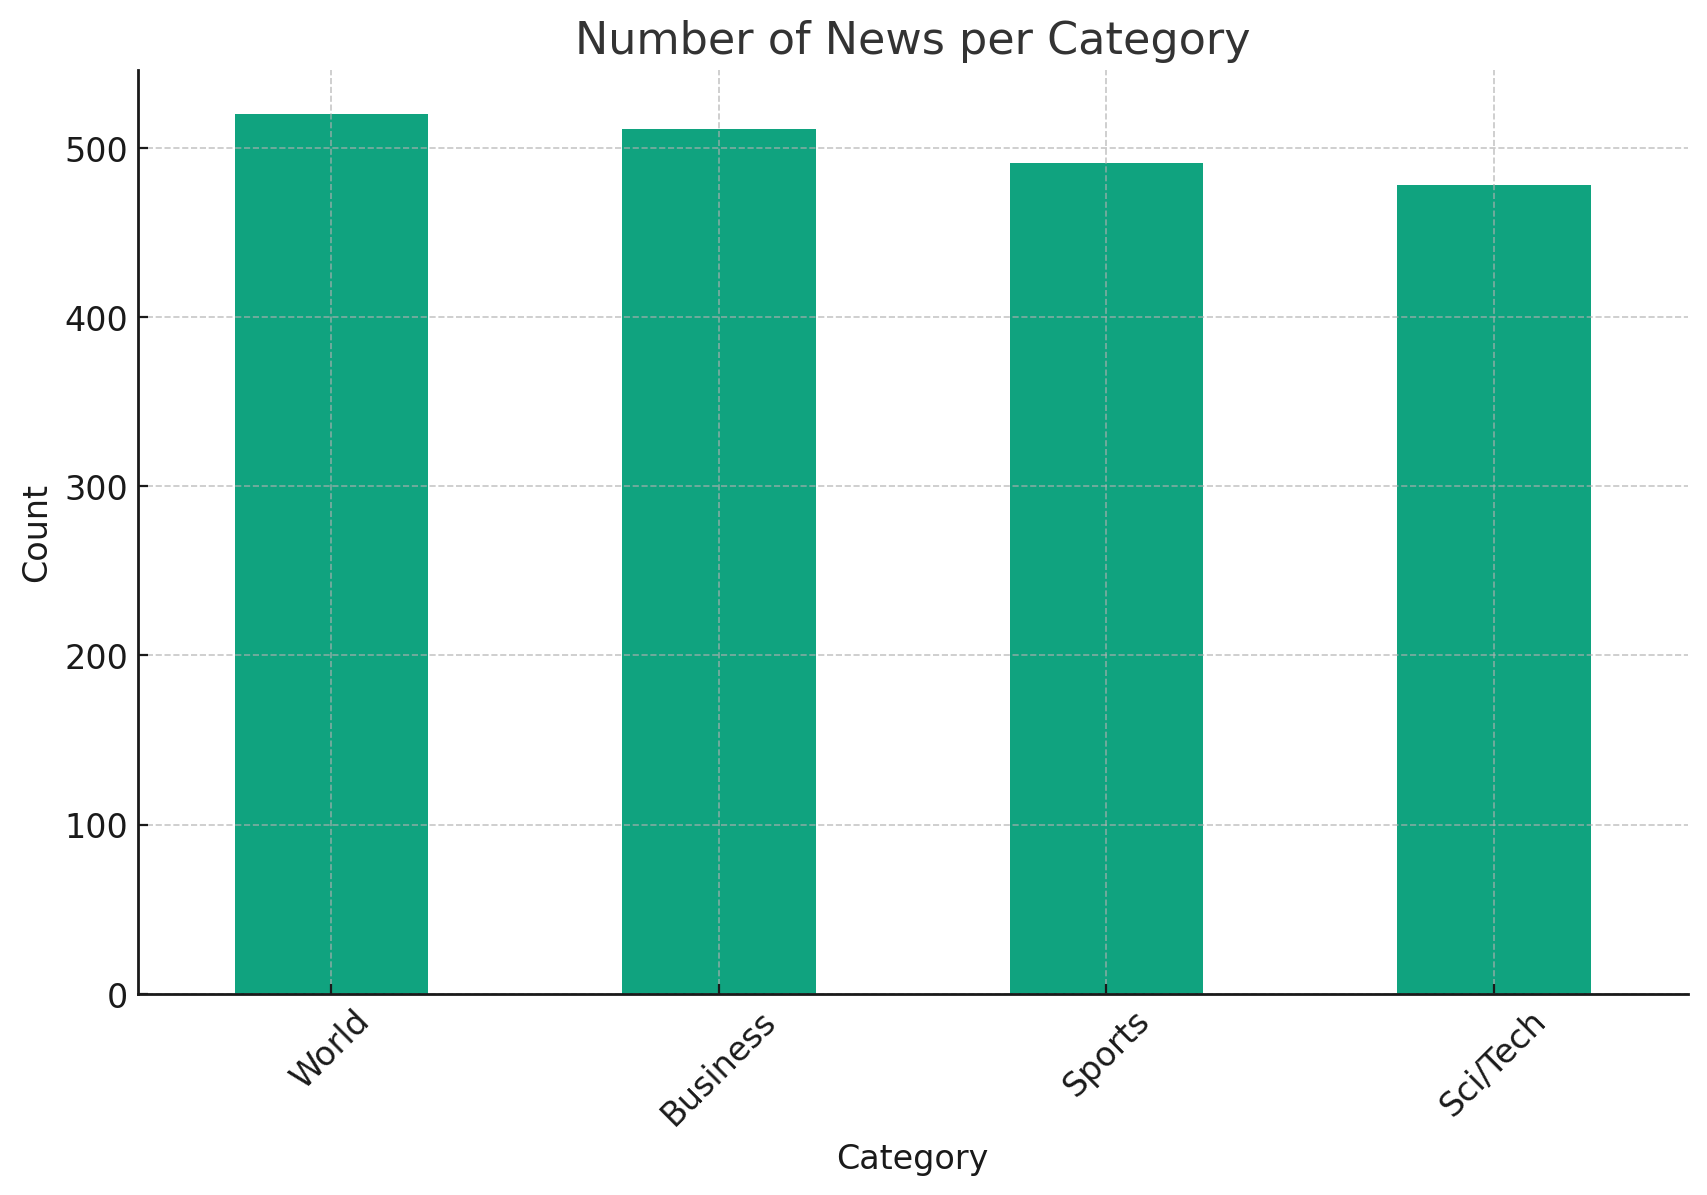

Here is the plot diagram showing the number of news entries per category, with 'label' on the x-axis and the count on the y-axis. As you can see, it visually represents the distribution of news across different categories in your dataset.



In [23]:
# Get the response
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

# Print only the last message (which is assistant's response)
message = messages.data[0]
for i, content in enumerate(message.content):
  if content.type == 'text':
    print(f"{content.text.value}\n")
  elif content.type == 'image_file':
    image_data = client.files.content(content.image_file.file_id)
    image_data_bytes = image_data.read()
    # Print the image
    from IPython.display import display, Image
    display(Image(data=image_data_bytes))
    # You can also save to a file
    with open("output/plot-image.png", "wb") as file:
      file.write(image_data_bytes)
      
    # Cleanup the file from OpenAI
    client.files.delete(content.image_file.file_id)

### Message annotations
Messages created by Assistants may contain annotations within the content array of the object. Annotations provide information around how you should annotate the text in the Message.

There are two types of Annotations:

1. `file_citation`: File citations are created by the `retrieval` tool and define references to a specific quote in a specific file that was uploaded and used by the Assistant to generate the response.
2. `file_path`: File path annotations are created by the `code_interpreter` tool and contain references to the files generated by the tool.

When annotations are present in the Message object, you'll see illegible model-generated substrings in the text that you should replace with the annotations. These strings may look something like 【13†source】 or sandbox:/mnt/data/file.csv. Here’s an example python code snippet that replaces these strings with information present in the annotations.

In [25]:
# Add a new message to the previously created thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="Can you create a new CSV file by removing all news in 'Business' category?"
)

run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

# Wait for Run to be completed
import time

while True:
    time.sleep(5)
    run = client.beta.threads.runs.retrieve(
      thread_id=thread.id,
      run_id=run.id
    )
    if run.status in ['queued', 'in_progress', 'requires_action', 'cancelling']:
        continue
    if run.status in ["completed", "expired", "failed", "cancelled"]:
        print(f"Run is {run.status}")
        break
    break

Run is completed


In [26]:
# Our response will only have `file_path` annotations. But the following code also handles `file_citation` annotations.

# Get the response
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

import os

# Print only the last message (which is assistant's response)
text = messages.data[0].content[0].text.value
print(f"_______Original text:_______\n{text}")

annotations = messages.data[0].content[0].text.annotations
citations = []
for i, annotation in enumerate(annotations):
    if (file_path := getattr(annotation, 'file_path', None)):
        cited_file = client.files.retrieve(file_path.file_id)
        cited_file_content = client.files.content(file_path.file_id)
        file_name = "output/" + os.path.basename(cited_file.filename)
        with open(file_name, "wb") as file:
          file.write(cited_file_content.read())
        text = text.replace(annotation.text, file_name)
    elif (file_citation := getattr(annotation, 'file_citation', None)):
        text = text.replace(annotation.text, f'[{i}]')
        cited_file = client.files.retrieve(file_citation.file_id)
        citations.append(f'[{i}] {file_citation.quote} from {cited_file.filename}')

# Add footnotes to the end of the message before displaying to user
if len(citations) > 0: 
  text += '\n' + '\n'.join(citations)
print(f"_______Processed text:_______\n{text}")

_______Original text:_______
It looks like I've already created a CSV file with news in the 'Business' category removed based on your previous request. 

You can download the already created filtered dataset using the provided link: [Download filtered_news.csv](sandbox:/mnt/data/filtered_news.csv).

If you need any further modifications or have any other requests, feel free to let me know!
_______Processed text:_______
It looks like I've already created a CSV file with news in the 'Business' category removed based on your previous request. 

You can download the already created filtered dataset using the provided link: [Download filtered_news.csv](output/filtered_news.csv).

If you need any further modifications or have any other requests, feel free to let me know!


### Input/Output Logs of Code Interpreter

By listing the steps of a Run that called Code Interpreter, you can inspect the code input and outputs logs of Code Interpreter

In [27]:
run_steps = client.beta.threads.runs.steps.list(
    thread_id=thread.id,
    run_id=run.id
)

for step in run_steps:
    if (tool_calls := getattr(step.step_details, 'tool_calls', None)):
        print_object(tool_calls)

In [28]:
# Cleanup
assistant_files = client.beta.assistants.files.list(assistant_id=assistant.id)
for file in assistant_files:
    client.files.delete(file_id=file.id)
client.beta.assistants.delete(assistant_id=assistant.id)
client.beta.threads.delete(thread_id=thread.id)

ThreadDeleted(id='thread_i8yp8ASOTK7Kj3Gv35v7pu3x', deleted=True, object='thread.deleted')

## Knowledge Retrieval

Retrieval augments the Assistant with knowledge from outside its model, such as proprietary product information or documents provided by your users. Once a file is uploaded and passed to the Assistant, OpenAI will automatically chunk your documents, index and store the embeddings, and implement vector search to retrieve relevant content to answer user queries.

Pass the `retrieval` in the `tools` parameter of the Assistant to enable Retrieval. The model then decides when to retrieve content based on the user Messages. The Assistants API automatically chooses between two retrieval techniques:
1. it either passes the file content in the prompt for short documents, or
2. performs a vector search for longer documents

### Using Files with Knowledge Retrieval
Similar to Code Interpreter, files can be passed at the Assistant-level or individual Message-level. When a file is attached at the Message-level, it is only accessible within the specific Thread the Message is attached to. After having uploaded a file, you can pass the ID of this File when creating the Message. 

Note that you are not charged based on the size of the files you upload via the Files API but rather based on which files you attach to a specific Assistant or Message that get indexed.

You can attach a maximum of 20 files per Assistant, and they can be at most 512 MB each. The size of all the files uploaded by your organization should not exceed 100 GB. You can request an increase in this storage limit using the [help center](https://help.openai.com/en/). In addition to the 512 MB file size limit, each file can only contain 2,000,000 tokens. Assistant or Message creation will fail if any attached files exceed the token limit.

You can also use the `AssistantFile` object to create, delete, or view associations between Assistant and File objects. Note that deleting an AssistantFile doesn’t delete the original File object, it simply deletes the association between that File and the Assistant. To delete a File, use the File delete endpoint instead.

### Supported files
For text/ MIME types, the encoding must be one of `utf-8`, `utf-16`, or `ascii`.

| FILE FORMAT | MIME TYPE                                                                 | CODE INTERPRETER  | RETRIEVAL  |
|-------------|---------------------------------------------------------------------------|-------------------|------------|
| .c          | text/x-c                                                                  |         ✓         |      ✓     |
| .cpp        | text/x-c++                                                                |         ✓         |      ✓     |
| .csv        | application/csv                                                           |         ✓         |      ✓     |
| .docx       | application/vnd.openxmlformats-officedocument.wordprocessingml.document   |         ✓         |      ✓     |
| .html       | text/html                                                                 |         ✓         |      ✓     |
| .java       | text/x-java                                                               |         ✓         |      ✓     |
| .json       | application/json                                                          |         ✓         |      ✓     |
| .md         | text/markdown                                                             |         ✓         |      ✓     |
| .pdf        | application/pdf                                                           |         ✓         |      ✓     |
| .php        | text/x-php                                                                |         ✓         |      ✓     |
| .pptx       | application/vnd.openxmlformats-officedocument.presentationml.presentation |         ✓         |      ✓     |
| .py         | text/x-python                                                             |         ✓         |      ✓     |
| .py         | text/x-script.python                                                      |         ✓         |      ✓     |
| .rb         | text/x-ruby                                                               |         ✓         |      ✓     |
| .tex        | text/x-tex                                                                |         ✓         |      ✓     |
| .txt        | text/plain                                                                |         ✓         |      ✓     |
| .css        | text/css                                                                  |         ✓         |            |
| .jpeg       | image/jpeg                                                                |         ✓         |            |
| .jpg        | image/jpeg                                                                |         ✓         |            |
| .js         | text/javascript                                                           |         ✓         |            |
| .gif        | image/gif                                                                 |         ✓         |            |
| .png        | image/png                                                                 |         ✓         |            |
| .tar        | application/x-tar                                                         |         ✓         |            |
| .ts         | application/typescript                                                    |         ✓         |            |
| .xlsx       | application/vnd.openxmlformats-officedocument.spreadsheetml.sheet         |         ✓         |            |
| .xml        | application/xml or "text/xml"                                             |         ✓         |            |
| .zip        | application/zip                                                           |         ✓         |            |

### Retrieval pricing
Retrieval is priced at 0.20 USD per GB per assistant per day. Attaching a single file ID to multiple assistants will incur the per assistant per day charge when the retrieval tool is enabled. For example, if you attach the same 1 GB file to two different Assistants with the retrieval tool enabled, you’ll be charged twice for this storage fee (2 * 0.20 USD per day). This fee does not vary with the number of end users and threads retrieving knowledge from a given assistant.

In addition, files attached to messages are charged on a per-assistant basis if the messages are part of a run where the retrieval tool is enabled. For example, running an assistant with retrieval enabled on a thread with 10 messages each with 1 unique file (10 total unique files) will incur a per-GB per-day charge on all 10 files (in addition to any files attached to the assistant itself).

### Deleting files
To remove a file from the assistant, you can detach the file from the assistant. Detaching the file from the assistant removes the file from the retrieval index and means you will no longer be charged for the storage of the indexed file.
```python
file_deletion_status = client.beta.assistants.files.delete(
  assistant_id=assistant.id,
  file_id=file.id
)
```


In [29]:
# Upload a file with an "assistants" purpose
file = client.files.create(
  file=open("data/Assistants_tools _OpenAI.pdf", "rb"),
  purpose='assistants'
)

# Create an assistant with 'retrieval' enabled and the file is added
assistant = client.beta.assistants.create(
    name = "OpenAI Assistant Tools",
    instructions="You are an assistant who is specialized on 'Tools that can be used with OpenAI Assistants'. You will retrieve the knowledge from the attached file to answer the questions. For the questions that are not related with your specilty, kindly reject to answer.",
    model="gpt-4-turbo-preview",
    tools=[{"type": "retrieval"}],
    file_ids=[file.id]
)

thread = client.beta.threads.create()

message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="What are the different type of tools that I can use with Assistants API?"
)

run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

# Wait for Run to be completed
import time

while True:
    time.sleep(5)
    run = client.beta.threads.runs.retrieve(
      thread_id=thread.id,
      run_id=run.id
    )
    if run.status in ['queued', 'in_progress', 'requires_action', 'cancelling']:
        continue
    if run.status in ["completed", "expired", "failed", "cancelled"]:
        print(f"Run is {run.status}")
        print(run.last_error)
        break
    break

Run is completed
None


In [30]:
# Ask an irrelevant question, see if it rejects. Normally ChatGPT with GPT-4 is responding this question.
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="What are the alternative solutions that I can use instead of Redis?"
)

run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

# Wait for Run to be completed
import time

while True:
    time.sleep(5)
    run = client.beta.threads.runs.retrieve(
      thread_id=thread.id,
      run_id=run.id
    )
    if run.status in ['queued', 'in_progress', 'requires_action', 'cancelling']:
        continue
    if run.status in ["completed", "expired", "failed", "cancelled"]:
        print(f"Run is {run.status}")
        break
    break

Run is completed


In [33]:
# Get the response
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

for message in reversed(messages.data):
  print(f"_______Role: {message.role}_______\n")
  # Process annotations before printing the text
  text = message.content[0].text.value
  annotations = message.content[0].text.annotations
  citations = []
  for i, annotation in enumerate(annotations):
      if (file_citation := getattr(annotation, 'file_citation', None)):
          text = text.replace(annotation.text, f'[{i}]')
          cited_file = client.files.retrieve(file_citation.file_id)
          citations.append(f'[{i}]: {cited_file.filename}')
  # Add footnotes to the end of the message before displaying to user
  if len(citations) > 0: 
    text += '\n' + '\n'.join(citations)
  print(f"{text}\n")

_______Role: user_______

What are the different type of tools that I can use with Assistants API?

_______Role: assistant_______

With the Assistants API, you can use a variety of tools, including:

1. **Code Interpreter**: Allows the assistant to interpret and run code.
2. **Knowledge Retrieval**: Enables the assistant to retrieve information from uploaded files.
3. **Function Calling**: This feature lets you describe functions to the Assistants, which can intelligently return the functions that need to be called along with their arguments[0][1].
[0]: Assistants_tools _OpenAI.pdf
[1]: Assistants_tools _OpenAI.pdf

_______Role: user_______

What are the alternative solutions that I can use instead of Redis?

_______Role: assistant_______

It seems the document does not contain information regarding alternative solutions to Redis. My search within the document provided results not related to your query. If you have other questions or need information on a different topic, feel free to 

In [34]:
# Cleanup
assistant_files = client.beta.assistants.files.list(assistant_id=assistant.id)
for file in assistant_files:
    client.files.delete(file_id=file.id)

client.beta.assistants.delete(assistant_id=assistant.id)
client.beta.threads.delete(thread_id=thread.id)

ThreadDeleted(id='thread_DfNnysZlb7xqixZUnEWWCnsP', deleted=True, object='thread.deleted')

## Function Calling
Similar to the Chat Completions API, the Assistants API supports function calling. Function calling allows you to describe functions to the Assistants and have it intelligently return the functions that need to be called along with their arguments. The Assistants API will pause execution during a Run when it invokes functions, and you can supply the results of the function call back to continue the Run execution.

When using the Function calling tool, the Run will move to a `required_action` state once the model determines the names and arguments of the functions to be called. You must then run those functions and submit the outputs before the run proceeds. If the outputs are not provided before the `expires_at` timestamp passes (roughly 10 mins past creation), the run will move to an `expired` status.

In [80]:
import json

# Example dummy function hard coded to return the same weather
# In production, this could be your backend API or an external API
def get_current_weather(location, unit="celsius"):
    """Get the current weather in a given location"""
    if "tokyo" in location.lower():
        return json.dumps({"location": "Tokyo", "temperature": "10", "unit": unit})
    elif "san francisco" in location.lower():
        return json.dumps({"location": "San Francisco", "temperature": "32", "unit": unit})
    elif "paris" in location.lower():
        return json.dumps({"location": "Paris", "temperature": "22", "unit": unit})
    else:
        return json.dumps({"location": location, "temperature": "unknown"})

In [81]:
# Create an assistant with the function(s) specified under 'tools' parameter.
assistant = client.beta.assistants.create(
    name = "Wheather Bot",
    instructions="You are a weather bot. Use the provided functions to answer questions.",
    model="gpt-4-turbo-preview",
    tools = [
    {
        "type": "function",
        "function": {
            "name": "get_current_weather",
            "description": "Get the current weather in a given location",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": "The city and state, e.g. San Francisco, CA",
                    },
                    "unit": {"type": "string", "enum": ["celsius", "fahrenheit"]},
                },
                "required": ["location"],
            },
        },
    }
    ]
)

thread = client.beta.threads.create()

message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="What is the weather like in Paris and Tokyo?"
)

run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

# Wait for Run to be completed
import time

while True:
    time.sleep(5)
    run = client.beta.threads.runs.retrieve(
      thread_id=thread.id,
      run_id=run.id
    )
    if run.status in ['queued', 'in_progress', 'cancelling']:
        continue
    if run.status in ['requires_action']:
        print_object(run.required_action)
        break
    if run.status in ["completed", "expired", "failed", "cancelled"]:
        print(f"Run is {run.status}")
        print(run.last_error)
        break
    break

{
    "submit_tool_outputs": {
        "tool_calls": [
            {
                "id": "call_FOREjw5nqQopMywBre68UrAp",
                "function": {
                    "arguments": "{\"location\": \"Paris, France\", \"unit\": \"celsius\"}",
                    "name": "get_current_weather"
                },
                "type": "function"
            },
            {
                "id": "call_y99BCHbtXcxWS5zYcsB1xaj9",
                "function": {
                    "arguments": "{\"location\": \"Tokyo, Japan\", \"unit\": \"celsius\"}",
                    "name": "get_current_weather"
                },
                "type": "function"
            }
        ]
    },
    "type": "submit_tool_outputs"
}


In [82]:
# The model can provide multiple functions to call at once using parallel function calling
if run.status in ['requires_action']:
    tool_outputs = []
    for call in run.required_action.submit_tool_outputs['tool_calls']:
        # Execute each funciton that the assistant asked you to call        
        function_to_call = globals().get(call['function']['name'])
        function_args = json.loads(call['function']['arguments'])
        function_response = function_to_call(
            location=function_args.get("location"),
            unit=function_args.get("unit"),
        )

        # Store the tool outputs to pass back to the assistant
        tool_outputs.append({
            "tool_call_id": call['id'],
            "output": function_response
        })

# Run the asssistant again with the tool_outputs
run = client.beta.threads.runs.submit_tool_outputs(
  thread_id=thread.id,
  run_id=run.id,
  tool_outputs=tool_outputs
)

while True:
    time.sleep(5)
    run = client.beta.threads.runs.retrieve(
      thread_id=thread.id,
      run_id=run.id
    )
    if run.status in ['queued', 'in_progress', 'cancelling']:
        continue
    if run.status in ['requires_action']:
        break
    if run.status in ["completed", "expired", "failed", "cancelled"]:
        print(f"Run is {run.status}")
        print(run.last_error)
        break
    break

Run is completed
None


In [83]:
# Get the response
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

for message in reversed(messages.data):
  print(f"_______Role: {message.role}_______\n")
  print(f"{message.content[0].text.value}\n")

_______Role: user_______

What is the weather like in Paris and Tokyo?

_______Role: assistant_______

The current weather is as follows:
- In Paris, France, the temperature is 22°C.
- In Tokyo, Japan, the temperature is 10°C.



In [84]:
# Cleanup
client.beta.assistants.delete(assistant_id=assistant.id)
client.beta.threads.delete(thread_id=thread.id)

ThreadDeleted(id='thread_oJU1SuzfimrNtFhuXuzt8Giu', deleted=True, object='thread.deleted')